In [37]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import resize, radon, iradon
from scipy.signal import convolve2d

In [38]:
phantom = shepp_logan_phantom()
phantom = resize(phantom, (128, 128), mode='reflect', anti_aliasing=True)

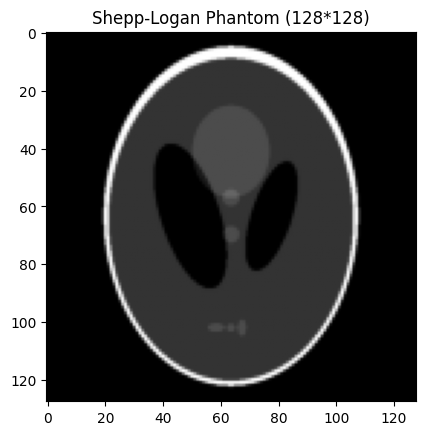

In [39]:
plt.imshow(phantom, cmap='gray')
plt.title('Shepp-Logan Phantom (128*128)')
plt.show()

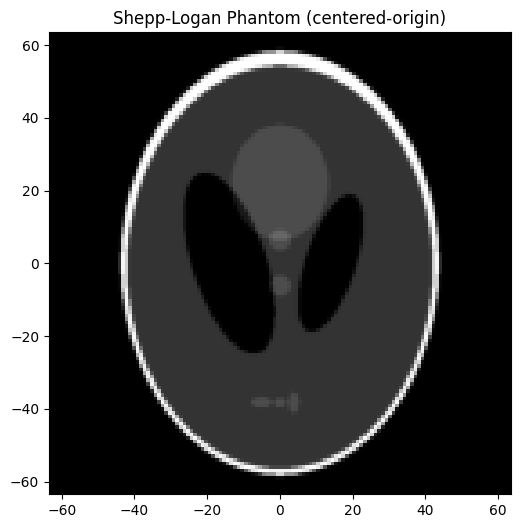

In [55]:
plt.figure(figsize=(6, 6))
extent = [-(phantom.shape[1]-1)/2, (phantom.shape[1]-1)/2,
          -(phantom.shape[0]-1)/2, (phantom.shape[0]-1)/2]
plt.imshow(phantom, cmap='gray', extent=extent)
plt.title('Shepp-Logan Phantom (centered-origin)')
plt.show()

(a)

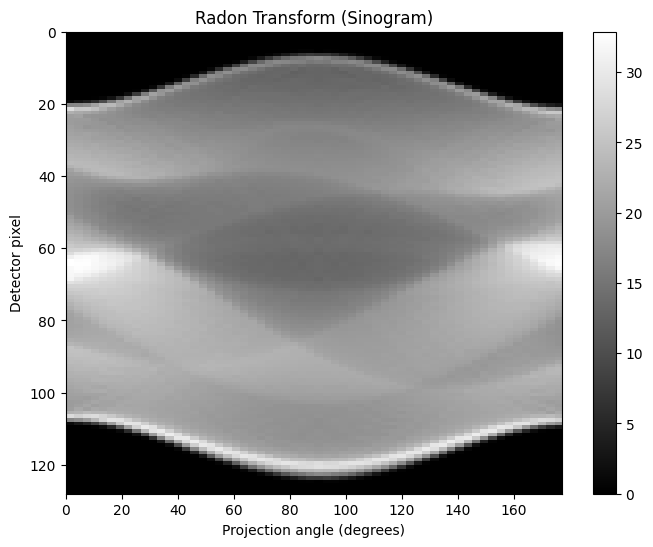

In [41]:
theta = np.arange(0, 180, 3)

sinogram = radon(phantom, theta=theta, circle=True)

plt.figure(figsize=(8,6))
plt.imshow(sinogram, cmap='gray', aspect='auto',
           extent=[theta[0], theta[-1], sinogram.shape[0], 0])
plt.xlabel('Projection angle (degrees)')
plt.ylabel('Detector pixel')
plt.title('Radon Transform (Sinogram)')
plt.colorbar()
plt.show()

In [42]:
def myFilter(sinogram, filter_type='ram-lak', L=0.5):
    n, n_angles = sinogram.shape
    freqs = np.fft.fftfreq(n, d=1.0)
    abs_freqs = np.abs(freqs)
    
    H = np.zeros(n)
    if filter_type.lower() == 'ram-lak':
        H = abs_freqs.copy()
    elif filter_type.lower() == 'shepp-logan':
        H = abs_freqs.copy()
        with np.errstate(divide='ignore', invalid='ignore'):
            factor = np.sin(np.pi * abs_freqs / (2 * L)) / (np.pi * abs_freqs / (2 * L))
            factor[abs_freqs==0] = 1.0
        H = H * factor
    elif filter_type.lower() == 'cosine':
        H = abs_freqs.copy()
        H = H * np.cos(np.pi * abs_freqs / (2 * L))
    
    H[abs_freqs > L] = 0
    
    filtered_sino = np.zeros_like(sinogram)
    
    for i in range(n_angles):
        proj = sinogram[:, i]
        proj_fft = np.fft.fft(proj)
        proj_fft_filtered = proj_fft * H
        proj_filtered = np.fft.ifft(proj_fft_filtered)
        filtered_sino[:, i] = np.real(proj_filtered)
    
    return filtered_sino


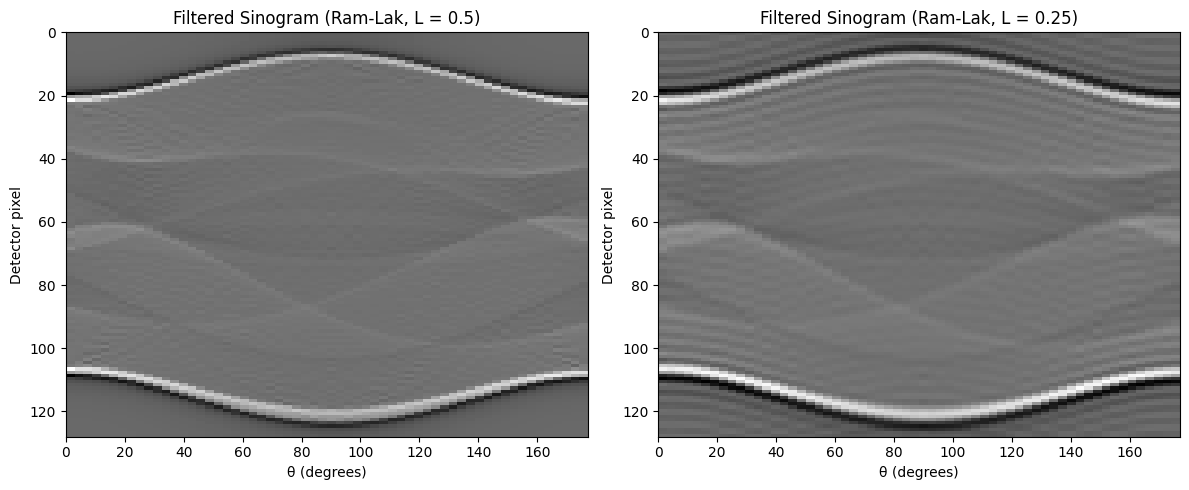

In [43]:
L1 = 0.5      
L2 = 0.5 / 2  

filter_types = ['ram-lak', 'shepp-logan', 'cosine']

filtered_sinos_L1 = {}
filtered_sinos_L2 = {}

for ftype in filter_types:
    filtered_sinos_L1[ftype] = myFilter(sinogram, filter_type=ftype, L=L1)
    filtered_sinos_L2[ftype] = myFilter(sinogram, filter_type=ftype, L=L2)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(filtered_sinos_L1['ram-lak'], cmap='gray', aspect='auto',
           extent=[theta[0], theta[-1], sinogram.shape[0], 0])
plt.title("Filtered Sinogram (Ram-Lak, L = 0.5)")
plt.xlabel("θ (degrees)")
plt.ylabel("Detector pixel")

plt.subplot(1,2,2)
plt.imshow(filtered_sinos_L2['ram-lak'], cmap='gray', aspect='auto',
           extent=[theta[0], theta[-1], sinogram.shape[0], 0])
plt.title("Filtered Sinogram (Ram-Lak, L = 0.25)")
plt.xlabel("θ (degrees)")
plt.ylabel("Detector pixel")
plt.tight_layout()
plt.show()


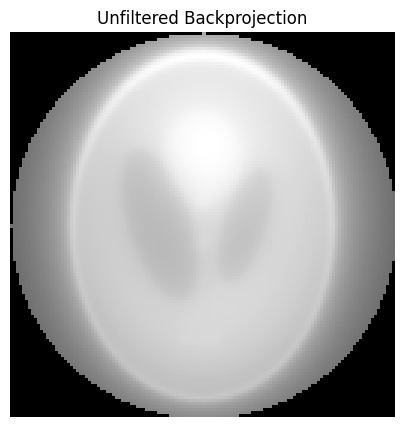

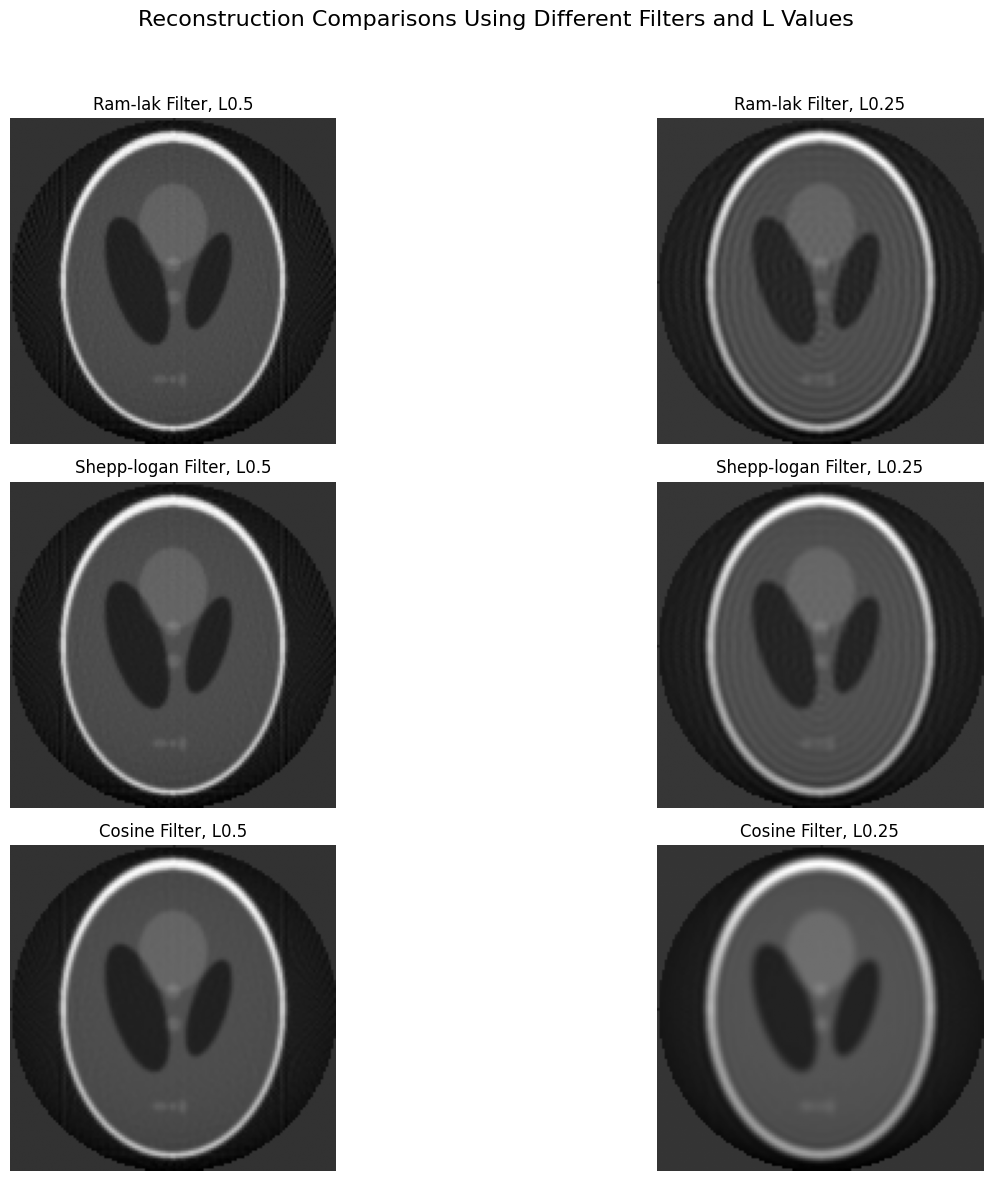

In [44]:
recon_unfiltered = iradon(sinogram, theta=theta, filter_name=None, circle=True)

reconstructions = {}  

for ftype in filter_types:
    reconstructions[f"{ftype}_L0.5"] = iradon(filtered_sinos_L1[ftype], theta=theta, filter_name=None, circle=True)
    reconstructions[f"{ftype}_L0.25"] = iradon(filtered_sinos_L2[ftype], theta=theta, filter_name=None, circle=True)

plt.figure(figsize=(5, 5))
plt.imshow(recon_unfiltered, cmap='gray')
plt.title("Unfiltered Backprojection")
plt.axis('off')
plt.show()

plt.figure(figsize=(16, 12))
plot_idx = 1
for ftype in filter_types:
    for L_val in ["L0.5", "L0.25"]:
        key = f"{ftype}_{L_val}"
        plt.subplot(3, 2, plot_idx)
        plt.imshow(reconstructions[key], cmap='gray')
        plt.title(f"{ftype.capitalize()} Filter, {L_val}")
        plt.axis('off')
        plot_idx += 1

plt.suptitle("Reconstruction Comparisons Using Different Filters and L Values", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Observations & Justifications:**

1. **Unfiltered Backprojection:**  
   The reconstruction image obtained by simply backprojecting the raw sinogram appears very blurred. This is also expected because unfiltered backprojection simply smears the projection data back over the image domain, which leads to a loss of high-frequency information and significant artifacts.

2. **Effect of the different Filter Type used:**

   - **Ram–Lak Filter:**  
     The Ram–Lak filter implements the ideal ramp (i.e. multiplication by |w|). When used with L = 0.5 (i.e. including all available frequencies), the reconstruction is sharp and shows high spatial resolution. But it may also amplify high-frequency noise. In contrast, when L is reduced to 0.25, the high-frequency components are comparatively strongly suppressed, which results in a smoother (less noisy) reconstruction, but some fine details are lost, leading to a slight blurring.

   - **Shepp–Logan Filter:**  
     The Shepp–Logan filter modifies the ramp by multiplying it with a sinc function. It reduces the amplification of high-frequency noise compared to the pure Ram–Lak filter. With L = 0.5, the image is reasonably sharp with less noise, and with L = 0.25, the reconstruction becomes even smoother (but also come with some loss in resolution).

   - **Cosine Filter:**  
     The Cosine filter multiplies the ramp by a cosine function, again attenuating the highest frequencies. Its behavior is similar to the Shepp–Logan filter in that it yields smoother reconstructions than the pure Ram–Lak filter. The effect of reducing L (i.e. L = 0.25) is similar – the image becomes smoother but with a slight loss of edge definition.

3. **Effect of the Parameter L:**  
   Here, the parameter L acts as a cutoff frequency:
   - **L = w_max (0.5 in our discrete setup):**  
     Nearly all frequencies up to the maximum are passed. This leads to a reconstruction with higher spatial resolution (i.e. sharper edges) but at the expense of increased high-frequency noise and potential aliasing artifacts.
   - **L = w_max/2 (0.25):**  
     A lower cutoff frequency means that high-frequency components are suppressed. The resulting image is smoother and has less noise, but some fine details and sharp edges are blurred.

In conclusion, we can infer that the pure Ram–Lak filter (with L = 0.5) gives the sharpest image but can be noisier. The Shepp–Logan and Cosine filters, by attenuating high frequencies, yield reconstructions that are smoother. Lowering L (to 0.25) in any filter further reduces noise and artifacts but causes a loss in resolution (blurring of edges).

(b)

In [45]:
S0 = phantom

In [46]:
def fspecial_gaussian(kernel_size, sigma):
    ax = np.arange(-kernel_size//2 + 1, kernel_size//2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel = kernel / np.sum(kernel)
    return kernel

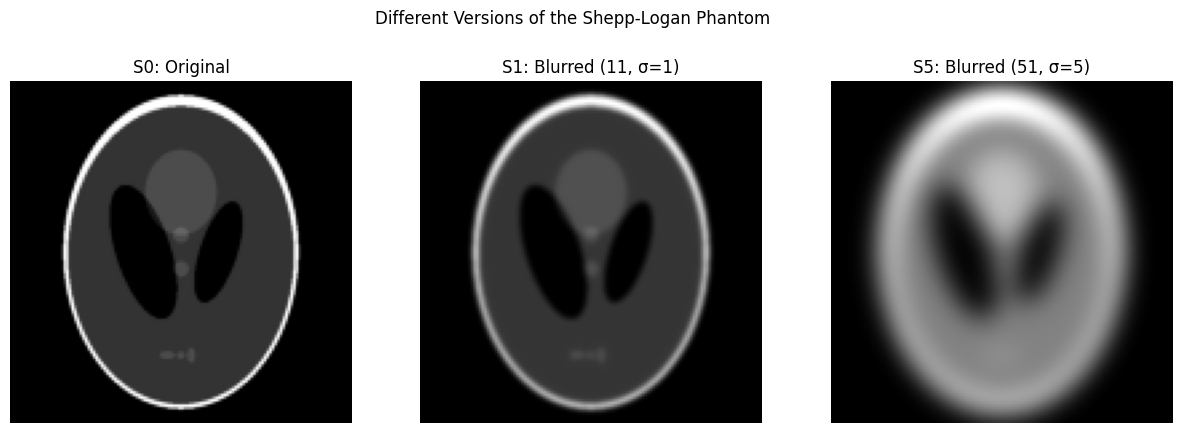

In [47]:
mask1 = fspecial_gaussian(11, 1)   
mask5 = fspecial_gaussian(51, 5)   

S1 = convolve2d(S0, mask1, mode='same')
S5 = convolve2d(S0, mask5, mode='same')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(S0, cmap='gray', extent=extent)
axs[0].set_title("S0: Original")
axs[0].axis('off')

axs[1].imshow(S1, cmap='gray', extent=extent)
axs[1].set_title("S1: Blurred (11, σ=1)")
axs[1].axis('off')

axs[2].imshow(S5, cmap='gray', extent=extent)
axs[2].set_title("S5: Blurred (51, σ=5)")
axs[2].axis('off')

plt.suptitle("Different Versions of the Shepp-Logan Phantom")
plt.show()

/home/ank/env/lib/python3.12/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


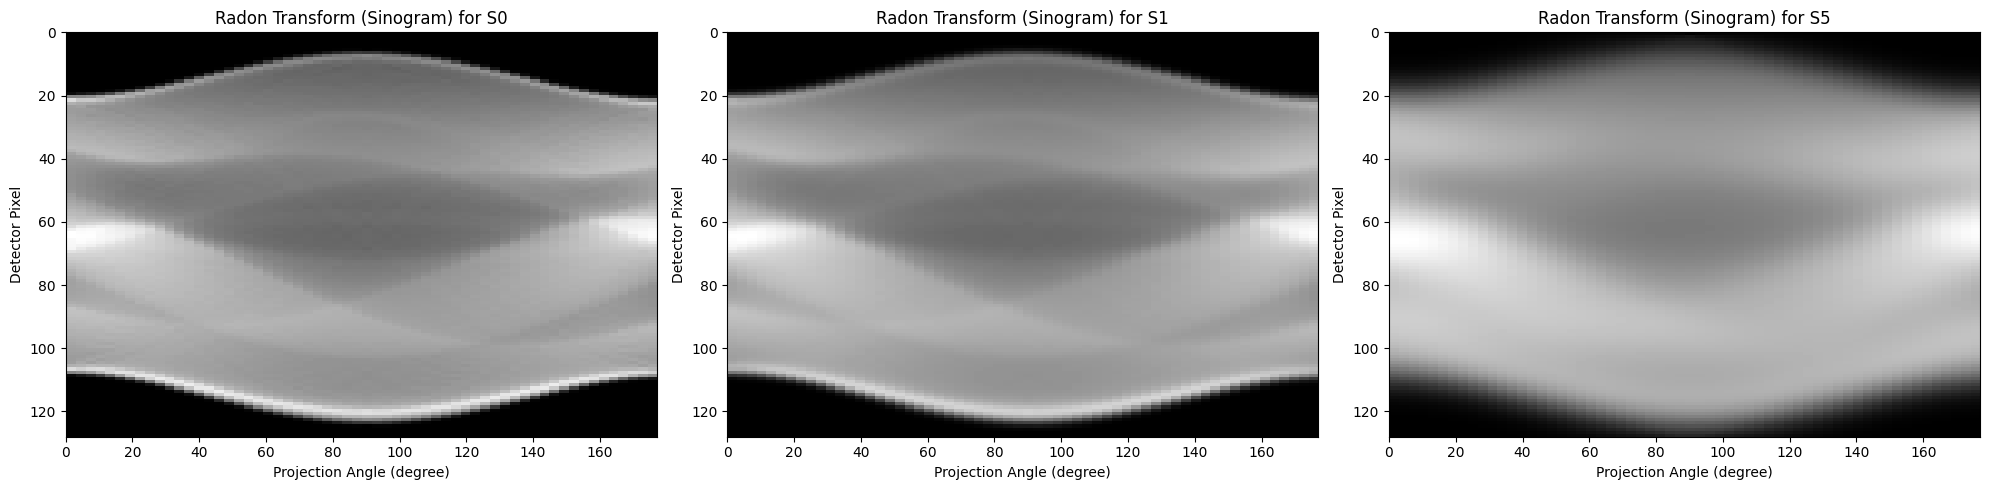

In [48]:
theta = np.arange(0, 180, 3)

sinogram_S0 = radon(S0, theta=theta, circle=True)
sinogram_S1 = radon(S1, theta=theta, circle=True)
sinogram_S5 = radon(S5, theta=theta, circle=True)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(sinogram_S0, cmap='gray', aspect='auto', extent=[theta[0], theta[-1], sinogram_S0.shape[0], 0])
axes[0].set_xlabel("Projection Angle (degree)")
axes[0].set_ylabel("Detector Pixel")
axes[0].set_title("Radon Transform (Sinogram) for S0")

axes[1].imshow(sinogram_S1, cmap='gray', aspect='auto', extent=[theta[0], theta[-1], sinogram_S1.shape[0], 0])
axes[1].set_xlabel("Projection Angle (degree)")
axes[1].set_ylabel("Detector Pixel")
axes[1].set_title("Radon Transform (Sinogram) for S1")

axes[2].imshow(sinogram_S5, cmap='gray', aspect='auto', extent=[theta[0], theta[-1], sinogram_S5.shape[0], 0])
axes[2].set_xlabel("Projection Angle (degree)")
axes[2].set_ylabel("Detector Pixel")
axes[2].set_title("Radon Transform (Sinogram) for S5")

plt.tight_layout()
plt.show()

In [49]:
def ram_lakFilter(sinogram, L=0.5):

    n, n_angles = sinogram.shape
    freqs = np.fft.fftfreq(n, d=1.0)
    abs_freqs = np.abs(freqs)
    
    H = abs_freqs.copy()
    H[abs_freqs > L] = 0
    
    filtered_sino = np.zeros_like(sinogram)
    
    for i in range(n_angles):
        proj = sinogram[:, i]
        proj_fft = np.fft.fft(proj)
        proj_fft_filtered = proj_fft * H
        proj_filtered = np.fft.ifft(proj_fft_filtered)
        filtered_sino[:, i] = np.real(proj_filtered)
    
    return filtered_sino

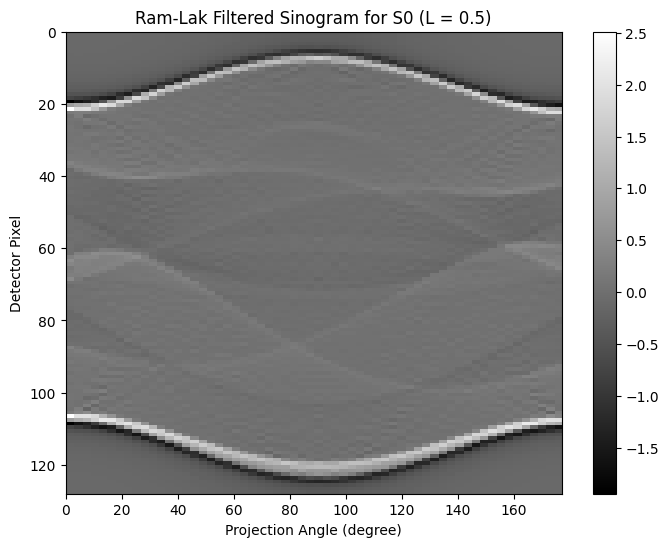

In [50]:
L_cutoff = 0.5

filtered_sino_S0 = ram_lakFilter(sinogram_S0, L=L_cutoff)
filtered_sino_S1 = ram_lakFilter(sinogram_S1, L=L_cutoff)
filtered_sino_S5 = ram_lakFilter(sinogram_S5, L=L_cutoff)

plt.figure(figsize=(8,6))
plt.imshow(filtered_sino_S0, cmap='gray', aspect='auto',
           extent=[theta[0], theta[-1], sinogram_S0.shape[0], 0])
plt.xlabel("Projection Angle (degree)")
plt.ylabel("Detector Pixel")
plt.title("Ram-Lak Filtered Sinogram for S0 (L = 0.5)")
plt.colorbar()
plt.show()

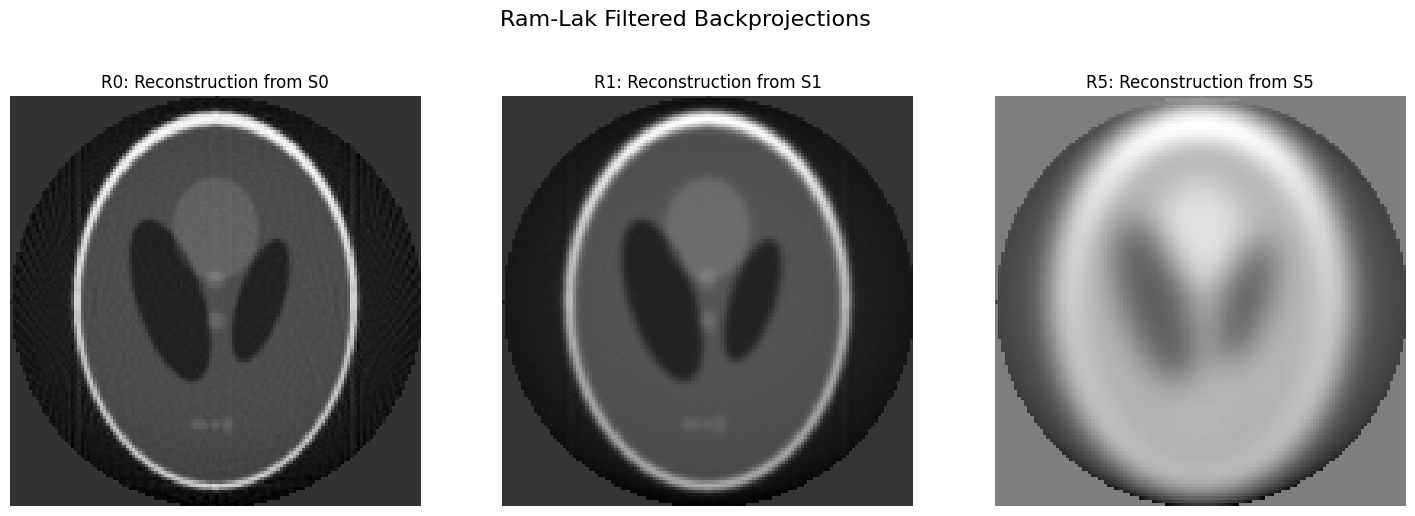

In [51]:
R0 = iradon(filtered_sino_S0, theta=theta, filter_name=None, circle=True)
R1 = iradon(filtered_sino_S1, theta=theta, filter_name=None, circle=True)
R5 = iradon(filtered_sino_S5, theta=theta, filter_name=None, circle=True)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(R0, cmap='gray')
axs[0].set_title("R0: Reconstruction from S0")
axs[0].axis('off')

axs[1].imshow(R1, cmap='gray')
axs[1].set_title("R1: Reconstruction from S1")
axs[1].axis('off')

axs[2].imshow(R5, cmap='gray')
axs[2].set_title("R5: Reconstruction from S5")
axs[2].axis('off')

plt.suptitle("Ram-Lak Filtered Backprojections", fontsize=16)
plt.show()

In [52]:
def compute_rrmse(A, B):
    return np.sqrt(np.sum((A - B)**2)) / np.sqrt(np.sum(A**2))

rrmse_S0_R0 = compute_rrmse(S0, R0)
rrmse_S1_R1 = compute_rrmse(S1, R1)
rrmse_S5_R5 = compute_rrmse(S5, R5)

print("RRMSE(S0, R0) = {:.4f}".format(rrmse_S0_R0))
print("RRMSE(S1, R1) = {:.4f}".format(rrmse_S1_R1))
print("RRMSE(S5, R5) = {:.4f}".format(rrmse_S5_R5))

RRMSE(S0, R0) = 0.6529
RRMSE(S1, R1) = 0.6612
RRMSE(S5, R5) = 0.7383


**Comparison between RRMSE values and their justification:**

   - **Lowest RRMSE (S0, R0):** As the original Shepp-Logan phantom \(S0\) contains the full range of high-frequency details, the Ram-Lak filter is optimized to restore these high frequencies during backprojection. As a result, the reconstruction \(R0\) retains more of the original detail. With an RRMSE of 0.6529, this case exhibits the lowest error, thus reflecting a good match between the original high-frequency content and the reconstruction.
   
   - **Intermediate RRMSE (S1, R1):** As the phantom \(S1\) is blurred using a moderate Gaussian kernel (11×11, σ=1), which causes a modest loss of high-frequency detail, the loss of some high-frequency content leads to a slight mismatch when the Ram-Lak filter (which emphasizes high frequencies) is applied. It exhibits a slightly higher RRMSE of 0.6612 compared to \(S0\), as the reconstruction error becomes a bit more pronounced relative to the energy of \(S1\).
   
   - **Highest RRMSE (S5, R5):** As the phantom \(S5\) is blurred using a heavy Guassian kernel (Gaussian kernel of 51×51, σ=5), which removes a significant portion of its high-frequency content and lowers its overall energy, further, when the same Ram-Lak filter is applied, the filter amplifies the sparse high-frequency components and any reconstruction artifacts. As the result, RRMSE increases to 0.7383, indicating that the reconstructed image \(R5\) deviates more from the initial \(S5\).


(c)

In [53]:
w_max = 0.5
L_values = np.linspace(w_max/50, w_max, 50)

rrmse_S0_vs_L = []
rrmse_S1_vs_L = []
rrmse_S5_vs_L = []

for L in L_values:
    filt_sino_S0 = myFilter(sinogram_S0, filter_type='ram-lak', L=L)
    recon_S0 = iradon(filt_sino_S0, theta=theta, filter_name=None, circle=True)
    rrmse_S0_vs_L.append(compute_rrmse(S0, recon_S0))
    
    filt_sino_S1 = myFilter(sinogram_S1, filter_type='ram-lak', L=L)
    recon_S1 = iradon(filt_sino_S1, theta=theta, filter_name=None, circle=True)
    rrmse_S1_vs_L.append(compute_rrmse(S1, recon_S1))
    
    filt_sino_S5 = myFilter(sinogram_S5, filter_type='ram-lak', L=L)
    recon_S5 = iradon(filt_sino_S5, theta=theta, filter_name=None, circle=True)
    rrmse_S5_vs_L.append(compute_rrmse(S5, recon_S5))


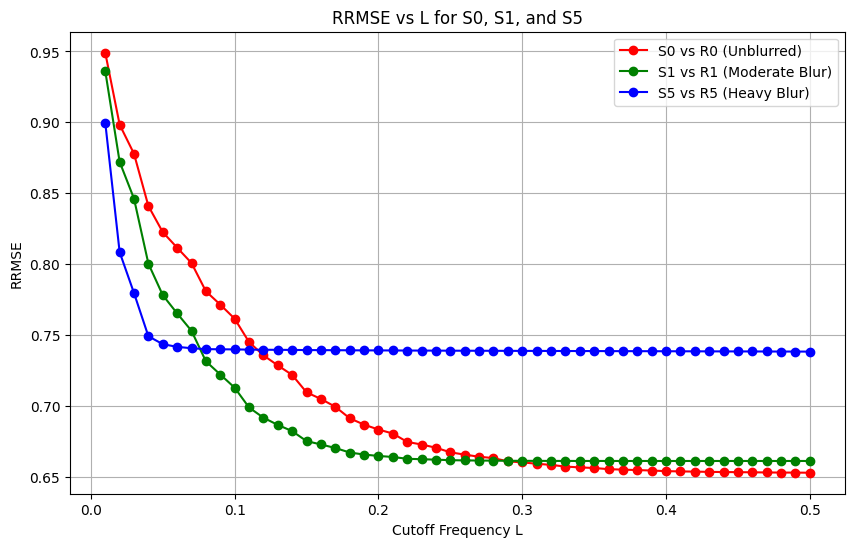

In [54]:
plt.figure(figsize=(10,6))
plt.plot(L_values, rrmse_S0_vs_L, 'r-o', label='S0 vs R0 (Unblurred)')
plt.plot(L_values, rrmse_S1_vs_L, 'g-o', label='S1 vs R1 (Moderate Blur)')
plt.plot(L_values, rrmse_S5_vs_L, 'b-o', label='S5 vs R5 (Heavy Blur)')
plt.xlabel('Cutoff Frequency L')
plt.ylabel('RRMSE')
plt.title('RRMSE vs L for S0, S1, and S5')
plt.legend()
plt.grid(True)
plt.show()


**Findings:**

1. **Reconstruction from Unblurred Phantom (S0, R0):**  
   - The RRMSE for (S0) tends to decrease as L increases and ultimately converges but it can be observed that it initially drops slowly with increasing L, but later converses to lowest RRMSE, in this case, we can infer that as L approaches $𝑤_{max}$, most of the significant frequency components are retained, leading to the lowest achievable RRMSE for (S0).

2. **Reconstruction from Moderately Blurred Phantom (S1, R1):**  
   - The RRMSE for the moderately blurred phantom (S1) also decreases with increasing L. Here, the decrease is steeper compared to the S0 case and ultimately, the RRMSE converges to a value slightly higher than that of the unblurred case. Here also, we can infer that increasing L still improves reconstruction by allowing more frequencies, but because (S1) inherently lacks some high-frequency details, it leads to slightly higher RRMSE.

3. **Reconstruction from Heavily Blurred Phantom (S5, R5):**  
   - The RRMSE for the heavily blurred phantom (S5) decreases very sharply as L increases but despite the sharp decrease, it converges to a higher RRMSE compared to (S0) and (S1). Here, heavy blurring has significantly removed high-frequency content. Thus, even with a high L, the reconstruction (R5) cannot fully restore (S5), leading to lowest RRMSE.
